# Biogeochemical Data Map

This notebook visualizes biogeochemical data from the Copernicus Marine Service for the California Current region.

**Prerequisites:**
- Run `python scripts/01_download_data.py` first to download the data

**Objectives:**
- Load biogeochemical data (NPP and zooplankton carbon) from NetCDF file
- Load California Current shapefile
- Create maps showing the data with the California Current boundary

## 1. Setup and Imports

In [1]:
# Import libraries
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from pathlib import Path
import numpy as np

%matplotlib inline

In [2]:
# Set up paths
data_dir = Path('../data/raw')
copernicus_dir = data_dir / 'copernicus'
shapefiles_dir = data_dir / 'shapefiles'
figures_dir = Path('../figures')

# Ensure figures directory exists
figures_dir.mkdir(parents=True, exist_ok=True)

## 2. Load Data

In [3]:
# Load Copernicus biogeochemical data
nc_file = copernicus_dir / 'copernicus_bgc_2024-06-01_2024-06-01.nc'

if not nc_file.exists():
    print("ERROR: NetCDF file not found!")
    print(f"Expected location: {nc_file}")
    print("\nPlease run the download script first:")
    print("  python scripts/01_download_data.py")
    raise FileNotFoundError(f"NetCDF file not found: {nc_file}")

print(f"Loading NetCDF file: {nc_file}")
ds = xr.open_dataset(nc_file)
print(f"Loaded dataset with {len(ds.data_vars)} variables")
ds

Loading NetCDF file: ../data/raw/copernicus/copernicus_bgc_2024-06-01_2024-06-01.nc
Loaded dataset with 2 variables


<xarray.Dataset> Size: 1MB
Dimensions:    (time: 1, latitude: 312, longitude: 280)
Coordinates:
  * time       (time) datetime64[ns] 8B 2024-06-01
  * latitude   (latitude) float32 1kB 21.92 22.0 22.08 ... 47.67 47.75 47.83
  * longitude  (longitude) float32 1kB -132.1 -132.0 -131.9 ... -108.9 -108.8
Data variables:
    zooc       (time, latitude, longitude) float64 699kB ...
    npp        (time, latitude, longitude) float64 699kB ...
Attributes: (12/15)
    Conventions:                      CF-1.7
    date_field:                       2024-12-31
    domain:                           global
    history:                          Created on 2025-09-11
    institution:                      CLS
    native_grid:                      Yin-Yang overset grid
    ...                               ...
    source_biogeochemical_variables:  OCEANCOLOUR_GLO_CHL_L4_REP_OBSERVATIONS...
    source_physical_variables:        GLOBAL_REANALYSIS_PHY_001_030 CMEMS pro...
    spatial_resolution:               0.083x0.083
    temporal_resolution:              1 day
    title:                            Global ocean low and mid trophic levels...
    copernicusmarine_version:         2.3.0

In [4]:
# Load California Current shapefile
shapefile_path = shapefiles_dir / 'california_current_lme.shp'
california_current = gpd.read_file(shapefile_path)
print(f"Loaded California Current shapefile: {len(california_current)} feature(s)")

Loaded California Current shapefile: 1 feature(s)


## 3. Explore Data

In [5]:
# Display data variables and their attributes
print("Data variables:")
for var in ds.data_vars:
    print(f"\n{var}:")
    print(f"  Shape: {ds[var].shape}")
    print(f"  Dimensions: {ds[var].dims}")
    if 'long_name' in ds[var].attrs:
        print(f"  Long name: {ds[var].attrs['long_name']}")
    if 'units' in ds[var].attrs:
        print(f"  Units: {ds[var].attrs['units']}")

Data variables:

zooc:
  Shape: (1, 312, 280)
  Dimensions: ('time', 'latitude', 'longitude')
  Units: g m-2

npp:
  Shape: (1, 312, 280)
  Dimensions: ('time', 'latitude', 'longitude')
  Units: mg m-2 day-1


In [6]:
# Display coordinate information
print("Coordinates:")
print(f"  Time: {ds.time.values}")
print(f"  Latitude range: {ds.latitude.min().values:.2f} to {ds.latitude.max().values:.2f}")
print(f"  Longitude range: {ds.longitude.min().values:.2f} to {ds.longitude.max().values:.2f}")
if 'depth' in ds.coords:
    print(f"  Depth levels: {ds.depth.values}")

Coordinates:
  Time: ['2024-06-01T00:00:00.000000000']
  Latitude range: 21.92 to 47.83
  Longitude range: -132.08 to -108.83


## 4. Create Maps


Figure saved to: ../figures/biogeochemical_map_2024-06-01.png


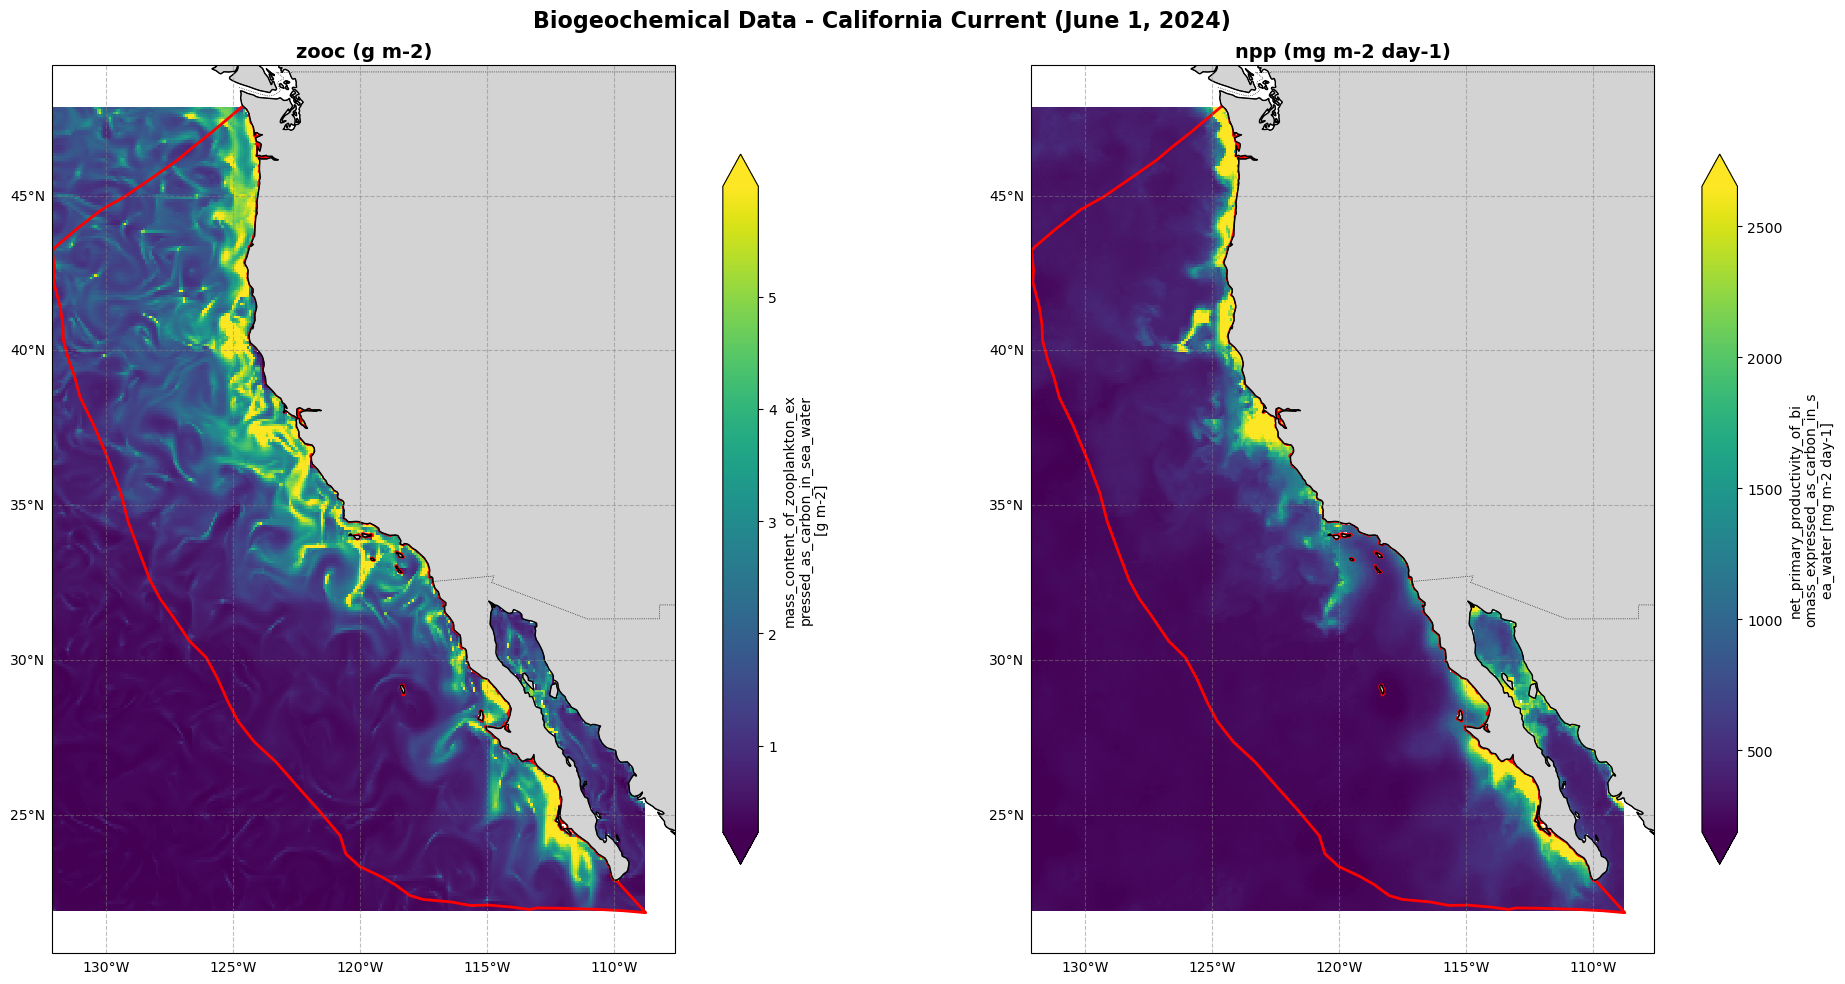

In [7]:
# Create figure with subplots for each variable
fig, axes = plt.subplots(1, 2, figsize=(20, 10),
                         subplot_kw={'projection': ccrs.PlateCarree()})

# Get the data for the first time step and first depth level (if applicable)
variables = list(ds.data_vars)

for idx, (ax, var) in enumerate(zip(axes, variables)):
    # Extract data
    data = ds[var].isel(time=0)
    if 'depth' in data.dims:
        data = data.isel(depth=0)
    
    # Plot data with stretched color scale for better contrast
    im = data.plot(ax=ax, transform=ccrs.PlateCarree(),
                   cmap='viridis', add_colorbar=True,
                   robust=True,  # Use 2nd and 98th percentiles for color limits
                   cbar_kwargs={'shrink': 0.8, 'pad': 0.05})
    
    # Overlay California Current boundary
    california_current.plot(ax=ax, facecolor='none', 
                           edgecolor='red', linewidth=2)
    
    # Add geographic features
    ax.add_feature(cfeature.LAND, facecolor='lightgray', edgecolor='black', zorder=1)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5, zorder=2)
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5, zorder=2)
    
    # Add gridlines
    gl = ax.gridlines(draw_labels=True, linestyle='--', alpha=0.5, color='gray')
    gl.top_labels = False
    gl.right_labels = False
    
    # Set title
    var_name = ds[var].attrs.get('long_name', var)
    var_units = ds[var].attrs.get('units', '')
    title = f"{var_name}"
    if var_units:
        title += f" ({var_units})"
    ax.set_title(title, fontsize=14, fontweight='bold')

# Add overall title
fig.suptitle('Biogeochemical Data - California Current (June 1, 2024)', 
             fontsize=16, fontweight='bold', y=0.98)

plt.tight_layout()

# Save figure
output_file = figures_dir / 'biogeochemical_map_2024-06-01.png'
plt.savefig(output_file, dpi=300, bbox_inches='tight')
print(f"\nFigure saved to: {output_file}")

plt.show()